In [1]:
import numpy as np
import random
np.random.seed(0)
random.seed(0)
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

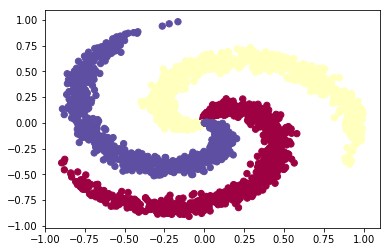

In [2]:
# generate data
N = 1000 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in xrange(K):
    ix = range(N*j,N*(j+1))
    r = np.linspace(0.0,1,N) # radius
    t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
    X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
    y[ix] = j
# lets visualize the data:
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()


In [3]:
def softmax(x):
    """
    compute softmax on the input vector or input matrix (rowwise)
    """
    num = np.exp(x)
    return num/np.sum(num, axis=1, keepdims=True)

def crossentropy_grad(ytrue, ypred):
    """
    returns dL/dypred
    """
    losses_grad = - ytrue/ypred
    losses_grad.shape = (losses_grad.shape[0], 1, K)
    return losses_grad

def softmax_grad(softmax_output):
    """
    requires: softmax output i.e ypred of one example
    returns: dypred/do , where o = W^T * X + b
    """
    return np.diag(softmax_output) - np.outer(softmax_output, softmax_output)

def weights_grad(x):
    """
    requires: one input example
    returns: do/dW which is the jacobian
    [x1, x2, ..., XD,  0,  0, ...,  0, ... ,  0,  0, ... , 0;
    0,  0, ...,  0, x1, x2, ..., xD, ... ,  0,  0, ... , 0;
    ...
    0,  0, ...,  0,  0,  0, ...,  0, ... , x1, x2, ..., xD;
    ] which is of dimension K * DK
    """
    wgrad = np.zeros((K, D*K))
    for i in range(K):
        wgrad[i, i*D : (i+1)*D] = x
    return wgrad

def bias_grad(K):
    """
    returns do/db
    """
    return np.eye(K)

def categorical_crossentropy(ytrue, ypred):
    return -np.sum(ytrue * np.log10(ypred), axis=1, keepdims=True)

def lw_grad(loss_grad, sftmx_grad, W_grad):
    """
    returns dL/dW
    """
    return np.dot(np.dot(loss_grad, sftmx_grad), W_grad)

def lb_grad(loss_grad, sftmx_grad, b_grad):
    """
    returns dL/db
    """
    return np.dot(np.dot(loss_grad, sftmx_grad), b_grad)

In [4]:
def plot_decision_boundary():
    # plot the resulting classifier
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], W) + b.T
    Z = np.argmax(Z, axis=1)
    Z = Z.reshape(xx.shape)
    fig = plt.figure()
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()

In [5]:
def fit(X, y, eta, W, b, loss_history, batch_size=16):
    batches = len(X)/batch_size
    X, y = shuffle(X, y)
    y_one_hot = np.eye(K)[y]
    for i in xrange(batches):
        # take care of last batch
        if i * batch_size > len(X):
            xbatch = X[i * batch_size:, :]
            ybatch = y_one_hot[i * batch_size:]
        else:
            xbatch = X[i * batch_size: (i+1) * batch_size, :]
            ybatch = y_one_hot[i * batch_size: (i+1) * batch_size]

        y_in = np.matmul(xbatch, W) + b.T
        ypred = softmax(y_in)

        losses = categorical_crossentropy(ybatch, ypred)
        batch_loss = np.mean(losses)
        loss_history.append(batch_loss)

        loss_grads = crossentropy_grad(ybatch, ypred)
        sftmx_grads = np.asarray(map(softmax_grad, ypred))
        W_grads = np.asarray(map(weights_grad, xbatch))
        b_grads = np.asarray(map(bias_grad, [K]*len(ybatch)))

        # dL/dW
        lW_g = np.mean(map(lw_grad, loss_grads, sftmx_grads, W_grads), axis=0)
        # dL/db
        lb_g = np.mean(map(lb_grad, loss_grads, sftmx_grads, b_grads), axis=0)

        # update
        W = W - eta * lW_g.reshape((K, D)).T
        b = b - eta * lb_g.T
        return W, b

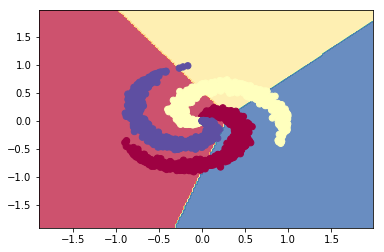

epoch  1
epoch  2
epoch  3
epoch  4
epoch  5
epoch  6
epoch  7
epoch  8
epoch  9
epoch  10


In [6]:
loss_history = []
W = np.random.random((D, K))
b = np.random.random((K, 1))
eta = 1 # learning rate
plot_decision_boundary()
for epoch in range(10):
    print "epoch ", epoch + 1
    W, b = fit(X, y, eta, W, b, loss_history, batch_size=100)
    eta *= 1

In [7]:
# evaluate training set accuracy
scores = np.dot(X, W) + b.T
predicted_class = np.argmax(scores, axis=1)
print 'training accuracy: %.2f' % (np.mean(predicted_class == y))

training accuracy: 0.56


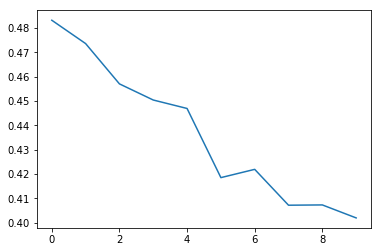

In [8]:
plt.plot(loss_history)
plt.show()

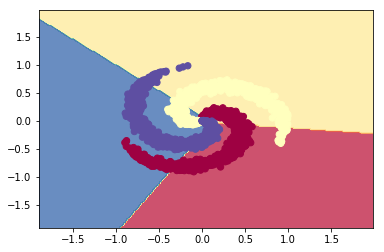

In [9]:
plot_decision_boundary()